In [3]:
# --- Step 1: Load Feature Data ---

import pandas as pd
import numpy as np

# Adjust the path if your features file has a different name or location
features_path = 'Data/features_df.csv'  # Change if needed
features_df = pd.read_csv(features_path)

# Check the columns and a sample
print(features_df.columns)
print(features_df.sample(5))

# --- Step 2: Prepare for LOSO Cross-Validation ---

# Ensure 'participant' and 'majority_activity' columns exist
assert 'participant' in features_df.columns, "Participant column missing!"
assert 'majority_activity' in features_df.columns, "Activity label column missing!"

participants = features_df['participant'].unique()
print(f"Participants found: {participants}")

# Ready for LOSO splitting

Index(['mean', 'std', 'skewness', 'max', 'min', 'range', 'psd_sum', 'psd_max',
       'majority_activity', 'participant'],
      dtype='object')
            mean       std  skewness        max       min      range  \
6171   10.590860  4.612359  0.220705  21.836725  1.602871  20.233853   
5751    9.736181  1.646264  0.709320  16.937265  3.546427  13.390838   
11321  10.236589  3.540561  0.788747  25.902412  1.405465  24.496947   
136    11.509971  4.514833  0.474278  26.922697  2.613561  24.309136   
3383    9.717137  1.981594 -0.091813  15.703103  4.842198  10.860905   

          psd_sum    psd_max majority_activity  participant  
6171   106.447740  20.736630        downstairs            5  
5751    11.418285   0.804521            biking            5  
11321   65.960149  11.287410        downstairs            9  
136    101.829447  18.321797           walking            1  
3383    19.758703   8.309464            biking            3  
Participants found: [ 1  2  3  4  5  6  7  8  9 10

In [4]:
# --- Step 3: LOSO Cross-Validation Splitting Example ---

# Let's demonstrate how to split the data for one participant (e.g., participant 1)
test_participant = participants[0]  # You can loop over participants for full LOSO

# Create train and test splits
train_df = features_df[features_df['participant'] != test_participant]
test_df = features_df[features_df['participant'] == test_participant]

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Check class distribution in train and test
print("Train activity distribution:")
print(train_df['majority_activity'].value_counts())
print("\nTest activity distribution:")
print(test_df['majority_activity'].value_counts())

Train set shape: (11321, 10)
Test set shape: (1260, 10)
Train activity distribution:
majority_activity
jogging       1629
biking        1629
standing      1620
downstairs    1619
sitting       1611
upstairs      1611
walking       1602
Name: count, dtype: int64

Test activity distribution:
majority_activity
jogging       181
biking        181
downstairs    181
standing      180
walking       179
sitting       179
upstairs      179
Name: count, dtype: int64


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# --- Step 4: LOSO Cross-Validation Loop with SVM ---

svm_results = []

for pid in participants:
    # Split data
    train_df = features_df[features_df['participant'] != pid]
    test_df = features_df[features_df['participant'] == pid]
    
    # Features and labels
    X_train = train_df.drop(['majority_activity', 'participant'], axis=1)
    y_train = train_df['majority_activity']
    X_test = test_df.drop(['majority_activity', 'participant'], axis=1)
    y_test = test_df['majority_activity']
    
    # Train SVM classifier
    n_features = X_train.shape[1]
    svm_clf = SVC(kernel='rbf', C=1, gamma=1/n_features, random_state=42)
    svm_clf.fit(X_train, y_train)
    
    # Predict
    y_pred = svm_clf.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    svm_results.append({'participant': pid, 'accuracy': acc, 'report': report})

    print(f"SVM Participant {pid} - Accuracy: {acc:.3f}")

# Optionally, aggregate results
mean_svm_acc = np.mean([r['accuracy'] for r in svm_results])
print(f"\nMean LOSO SVM Accuracy: {mean_svm_acc:.3f}")

SVM Participant 1 - Accuracy: 0.717
SVM Participant 2 - Accuracy: 0.747
SVM Participant 3 - Accuracy: 0.625
SVM Participant 4 - Accuracy: 0.713
SVM Participant 5 - Accuracy: 0.747
SVM Participant 6 - Accuracy: 0.794
SVM Participant 7 - Accuracy: 0.798
SVM Participant 8 - Accuracy: 0.878
SVM Participant 9 - Accuracy: 0.787
SVM Participant 10 - Accuracy: 0.487

Mean LOSO SVM Accuracy: 0.729


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Reduced parameter grid for SVM, including 'poly' kernel but fewer values
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [2, 3]  # Only used for 'poly' kernel
}

param_grid_reduced = {
    'C': [0.1, 1],
    'gamma': ['scale', 0.01,0.025, 0.1, 0.05],
    'kernel': ['rbf']
    #
}

# Use a subset of the training data for speed if needed
X_sample = X_train
y_sample = y_train

# Grid search with 3-fold cross-validation (faster)
grid = GridSearchCV(SVC(random_state=42), param_grid_reduced, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_sample, y_sample)

print("Best parameters found:", grid.best_params_)
print(f"Best cross-validation accuracy: {grid.best_score_:.3f}")

# Train SVM with best parameters on full training set
svm_best = SVC(**grid.best_params_, random_state=42)
svm_best.fit(X_train, y_train)
y_pred_best = svm_best.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
print(f"Test accuracy with best SVM: {acc_best:.3f}")
print(classification_report(y_test, y_pred_best))

Best parameters found: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.721
Test accuracy with best SVM: 0.819
              precision    recall  f1-score   support

      biking       0.96      1.00      0.98       181
  downstairs       0.37      0.13      0.20       181
     jogging       0.99      0.99      0.99       181
     sitting       0.99      0.92      0.96       179
    standing       0.96      0.97      0.97       180
    upstairs       0.53      0.87      0.66       179
     walking       0.82      0.85      0.84       179

    accuracy                           0.82      1260
   macro avg       0.80      0.82      0.80      1260
weighted avg       0.80      0.82      0.80      1260



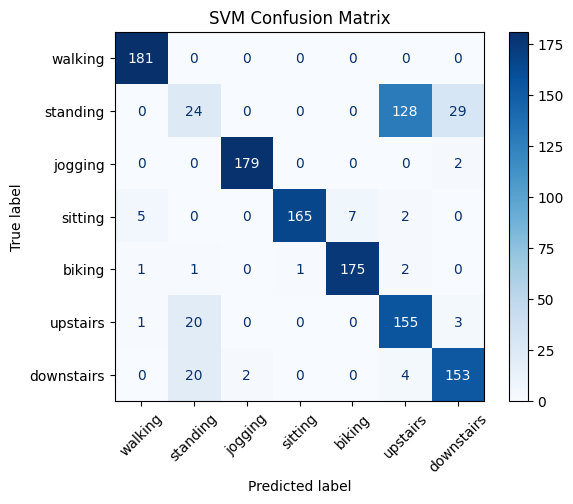

In [16]:
# Checking the confusion matrix to understand misclassifications
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= features_df['majority_activity'].unique())
disp.plot(cmap=plt.cm.Blues)
plt.title("SVM Confusion Matrix")
plt.xticks(rotation = 45)
plt.show()

## Random Forest Classifier using LOSO Cross-Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# --- Step 4: LOSO Cross-Validation Loop with Hyperparameter Optimization ---

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10],
    #'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'criterion': [ 'entropy']
}

results = []

for pid in participants:
    # Split data
    train_df = features_df[features_df['participant'] != pid]
    test_df = features_df[features_df['participant'] == pid]
    
    # Features and labels
    X_train = train_df.drop(['majority_activity', 'participant'], axis=1)
    y_train = train_df['majority_activity']
    X_test = test_df.drop(['majority_activity', 'participant'], axis=1)
    y_test = test_df['majority_activity']
    
    # Hyperparameter tuning with GridSearchCV (3-fold CV for speed)
    grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    
    # Train classifier with best parameters
    clf = RandomForestClassifier(**best_params, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({'participant': pid, 'accuracy': acc, 'report': report, 'best_params': best_params})

    print(f"Participant {pid} - Accuracy: {acc:.3f} - Best Params: {best_params}")

# Optionally, aggregate results
mean_acc = np.mean([r['accuracy'] for r in results])
print(f"\nMean LOSO Accuracy: {mean_acc:.3f}")

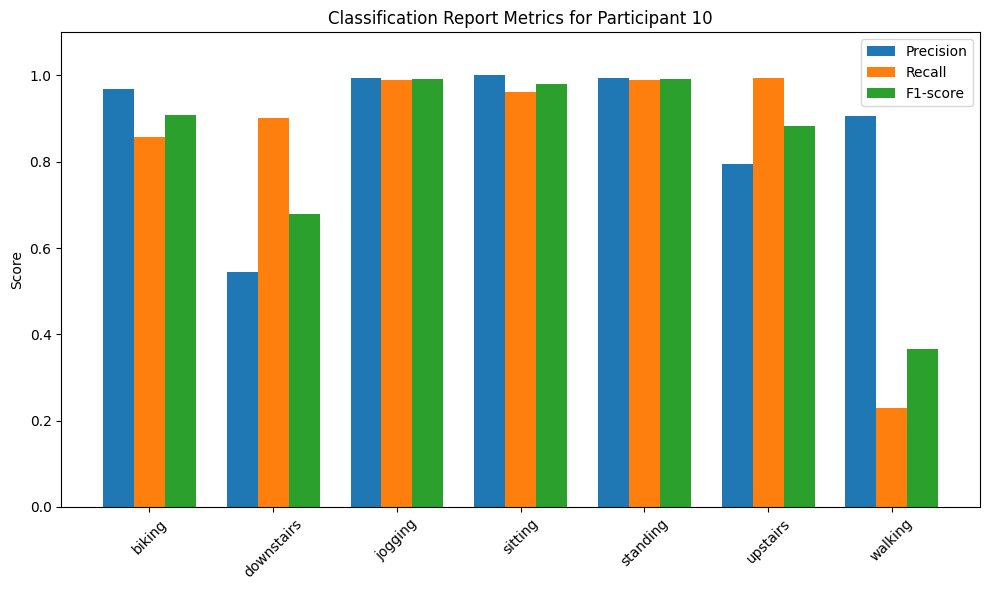

In [ ]:
# --- Step 5: Visualize Classification Report for Last Participant ---

import matplotlib.pyplot as plt

# Extract per-class metrics from the last report
labels = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-score')

ax.set_ylabel('Score')
ax.set_title(f'Classification Report Metrics for Participant {pid}')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()

In [22]:
# --- Step 4: LOSO Cross-Validation Loop with Hyperparameter Optimization ---

param_grid = {
    'n_estimators': [100],  # Reduced for speed
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 20],
    'max_features': ['sqrt'],
    'criterion': ['entropy']
}

results = []
feature_importances = []
all_y_true = []
all_y_pred = []

for pid in participants:
    train_df = features_df[features_df['participant'] != pid]
    test_df = features_df[features_df['participant'] == pid]
    
    X_train = train_df.drop(['majority_activity', 'participant'], axis=1)
    y_train = train_df['majority_activity']
    X_test = test_df.drop(['majority_activity', 'participant'], axis=1)
    y_test = test_df['majority_activity']
    
    grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=2, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    
    clf = RandomForestClassifier(**best_params, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Collect for confusion matrix
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results.append({'participant': pid, 'accuracy': acc, 'report': report, 'best_params': best_params})
    feature_importances.append(clf.feature_importances_)
    
    print(f"Participant {pid} - Accuracy: {acc:.3f} - Best Params: {best_params}")

mean_acc = np.mean([r['accuracy'] for r in results])
print(f"\nMean LOSO Accuracy: {mean_acc:.3f}")



Participant 1 - Accuracy: 0.721 - Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}
Participant 2 - Accuracy: 0.863 - Best Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}
Participant 3 - Accuracy: 0.802 - Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}
Participant 4 - Accuracy: 0.670 - Best Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}
Participant 5 - Accuracy: 0.692 - Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}
Participant 6 - Accuracy: 0.871 - Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}
Participant 7 - Accuracy: 0.710 - Best Par

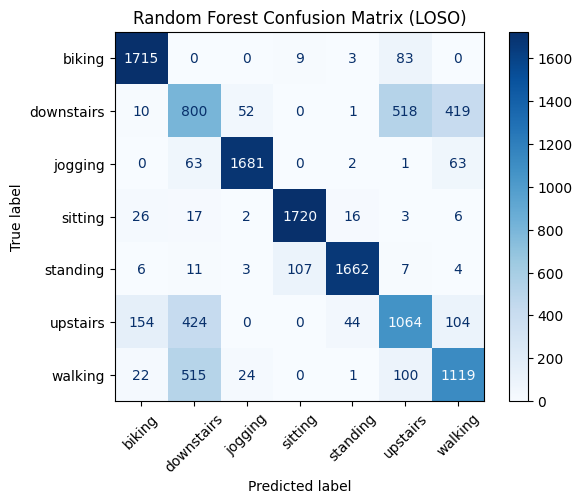

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = sorted(features_df['majority_activity'].unique())  
cm = confusion_matrix(all_y_true, all_y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix (LOSO)")
plt.xticks(rotation=45)
plt.show()

consistent problem of predicting Upstairs instead of Downstairs and vice versa (---later addition of ay feature)

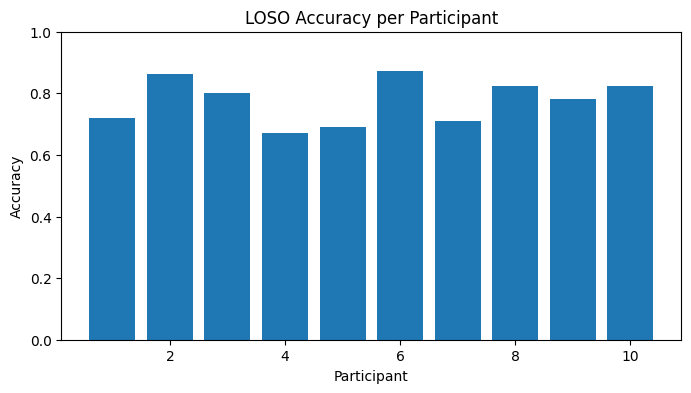

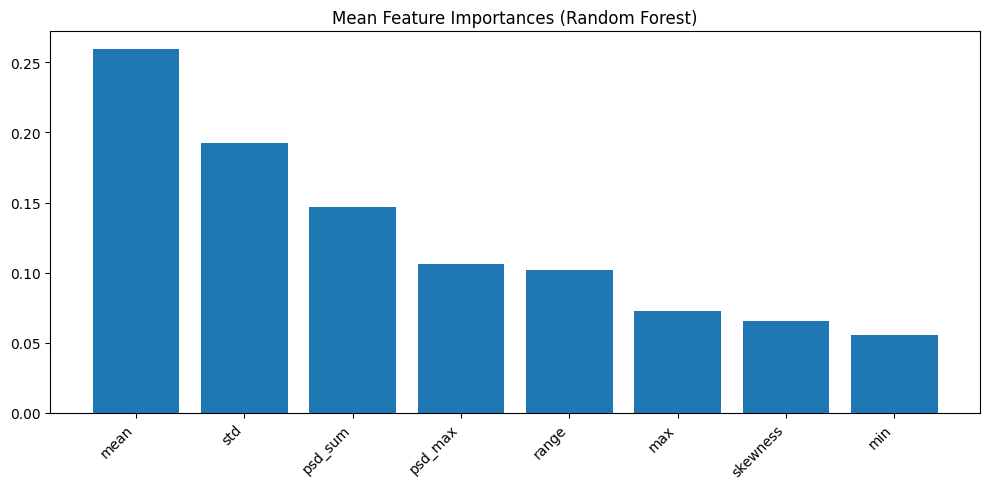

In [24]:
# --- Plotting ---

# Plot per-participant accuracy
plt.figure(figsize=(8, 4))
plt.bar([r['participant'] for r in results], [r['accuracy'] for r in results])
plt.xlabel('Participant')
plt.ylabel('Accuracy')
plt.title('LOSO Accuracy per Participant')
plt.ylim(0, 1)
plt.show()

# Plot mean feature importances
mean_importances = np.mean(feature_importances, axis=0)
feature_names = X_train.columns
indices = np.argsort(mean_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(mean_importances)), mean_importances[indices])
plt.xticks(range(len(mean_importances)), feature_names[indices], rotation=45, ha='right')
plt.title('Mean Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

#### Mean Feature Importances Result from Random Forest
Top 3:

- Mean 
- Std
- Psd Sum

### need for confusion matrix


In [27]:
from sklearn.neural_network import MLPClassifier

# Define and train MLP with 2 hidden layer and momentum
mlp = MLPClassifier(hidden_layer_sizes=(20,10), solver='sgd',
                    momentum=0.9, max_iter=1000, random_state=42) # maybe stop error criteria
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred_mlp = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Test Accuracy: {mlp_acc:.3f}")
print(classification_report(y_test, y_pred_mlp))

MLP Test Accuracy: 0.554
              precision    recall  f1-score   support

      biking       0.91      0.49      0.63       181
  downstairs       0.12      0.15      0.13       171
     jogging       1.00      0.98      0.99       181
     sitting       0.58      0.95      0.72       179
    standing       0.96      0.28      0.43       180
    upstairs       0.57      0.93      0.71       179
     walking       0.10      0.06      0.08       170

    accuracy                           0.55      1241
   macro avg       0.61      0.55      0.53      1241
weighted avg       0.61      0.55      0.53      1241



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [
        #(10,),         # 1 layer, 10 neurons
        #(20,),         # 1 layer, 20 neurons
        (10, 10),      # 2 layers, 10 neurons each
        (20, 10),      # 2 layers, 20 and 10 neurons
        (30,30),      # 2 layers, 30 neurons each
        (20, 20, 10),  # 3 layers # occam's razor!
    ],
    'activation': [ 'tanh'], # Activation function tested on relu and tanh (tanh is better)
    #'solver': ['adam','sgd'],  # 'adam' is often better for MLPs
    'solver': ['sgd'],
    'max_iter': [500],
    'momentum': [0.95],  # Momentum for SGD
    'alpha': [0.0001, 0.001],  # Regularization term
}

mlp = MLPClassifier(random_state=42)
grid = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

Best parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (20, 10), 'max_iter': 500, 'momentum': 0.95, 'solver': 'sgd'}
Best cross-validation accuracy: 0.7230158730158731


Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (20, 10), 'max_iter': 500, 'momentum': 0.95, 'solver': 'sgd'}
Best cross-validation accuracy: 0.7204585537918872

Best parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (20, 10), 'max_iter': 500, 'momentum': 0.95, 'solver': 'sgd'}
Best cross-validation accuracy: 0.7230158730158731

MLP Test Accuracy: 0.771
              precision    recall  f1-score   support

      biking       0.97      0.90      0.93       181
  downstairs       0.43      0.51      0.47       171
     jogging       1.00      0.99      0.99       181
     sitting       0.85      0.96      0.90       179
    standing       0.98      0.82      0.89       180
    upstairs       0.78      0.99      0.87       179
     walking       0.28      0.18      0.22       170

    accuracy                           0.77      1241
   macro avg       0.76      0.76      0.75      1241
weighted avg       0.76      0.77      0.76      1241



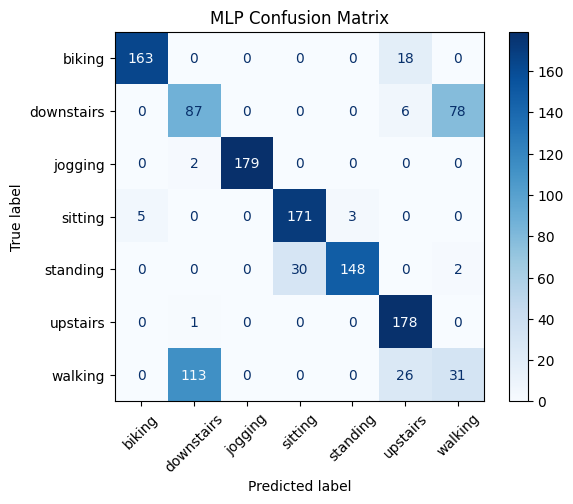

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Train MLP Classifier 2 hidden layers with best parameters (adam solver: adapts the learning rate for each parameter otherwise sgd with momentum)
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), solver='adam',
                    momentum=0.9, max_iter=10000, random_state=42)
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred)
print(f"MLP Test Accuracy: {mlp_acc:.3f}")
print(classification_report(y_test, y_pred))

# Confusion matrix
class_names = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("MLP Confusion Matrix")
plt.xticks(rotation=45)
plt.show()
